In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from pyproj import Transformer

start_date = np.datetime64('2024-09-25 00:00:00')
end_date = np.datetime64('2024-09-28 00:00:00')

# read COAWST model results
# John's Helene hindcast
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
time_all = dsm.ocean_time.values
idxms = int( np.where(time_all >= start_date)[0][0] )
idxme = int( np.where(time_all <= end_date)[0][-1] )
timem = time_all[idxms:idxme]
mask_rho = dsm.mask_rho.values
# TODO - change the time of the wet-dry mask
#wd_mask_rho = dsm.wetdry_mask_rho[19,:,:].values
wd_mask_rho = dsm.mask_rho[:,:].values

# Find closest model grid point
# Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
model_shape = np.shape( lonm )
print('model shape: ',model_shape)
print('nlat, nlon: ',np.shape(mask_rho))


model shape:  (512, 833)
nlat, nlon:  (512, 833)


In [2]:
# Extract the depth, latitude, longitude, and mask (0=land, 1=water)
h = dsm['h'].values
lat = dsm['lat_rho'].values
lon = dsm['lon_rho'].values
mask = wd_mask_rho

In [3]:
# Model grid: lon_grid, lat_grid (2D arrays)
# convert to UTM
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
xm, ym = transformer.transform(lon, lat)
# find differences in model grid spacing
dxm = np.diff(xm)
dym = np.diff(ym)
print('Model spacing: xmean {:.1f}, xmin {:.1f} xmax {:.1f}'.format( np.mean(dxm), np.min(dxm), np.max(dxm) ) )
print('Model spacing: ymean {:.1f}, ymin {:.1f} ymax {:.1f}'.format( np.mean(dym), np.min(dym), np.max(dym) ) )

Model spacing: xmean 1491.1, xmin 1351.1 xmax 1601.2
Model spacing: ymean 727.2, ymin 612.1 ymax 835.3


Text(0, 0.5, 'Latitude')

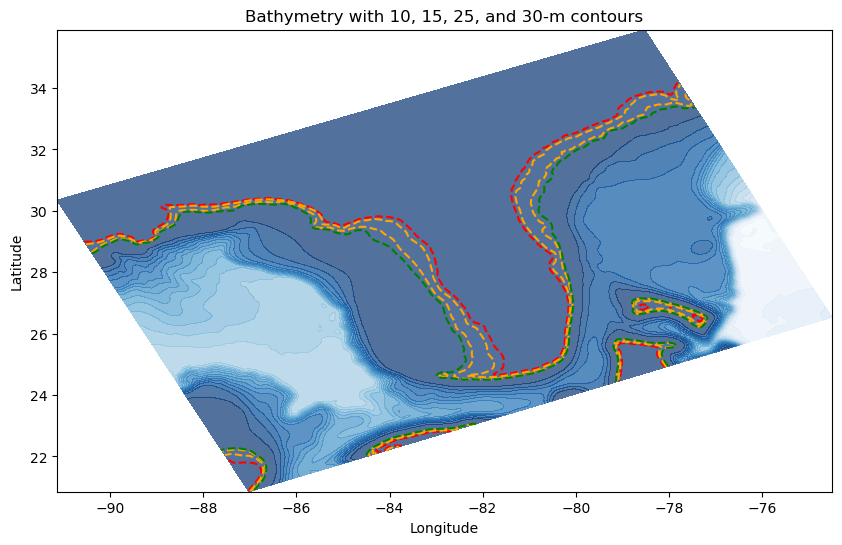

In [4]:
# Plot the depth and  contour
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(lon, lat, -h, levels=[-10], colors='red')
contour_15 = plt.contour(lon, lat, -h, levels=[-15], colors='orange')
contour_25 = plt.contour(lon, lat, -h, levels=[-25], colors='orange')
contour_30 = plt.contour(lon, lat, -h, levels=[-30], colors='green')

plt.title(f"Bathymetry with 10, 15, 25, and 30-m contours")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Northing (m)')

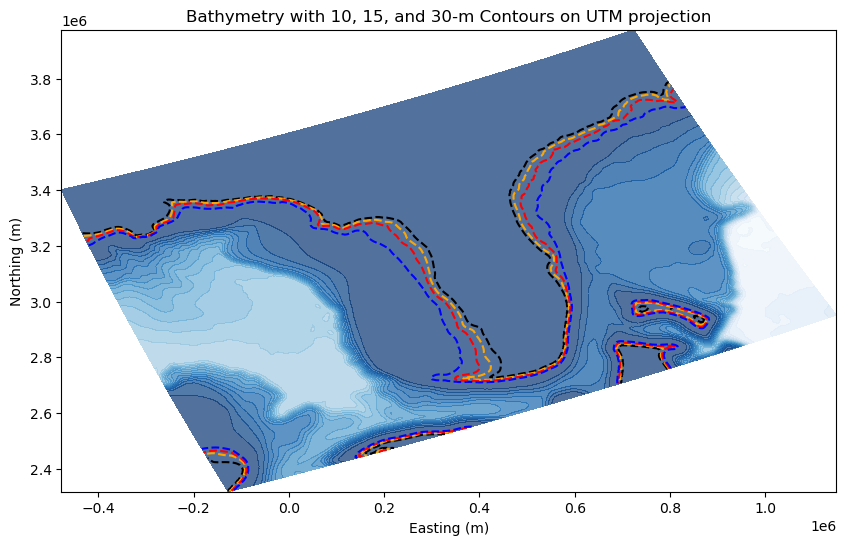

In [11]:
# Plot the depth and  contour
plt.figure(figsize=(10, 6))
plt.contourf(xm, ym, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(xm, ym, -h, levels=[-10], colors='black')
contour_15 = plt.contour(xm, ym, -h, levels=[-15], colors='orange')
contour_20 = plt.contour(xm, ym, -h, levels=[-20], colors='red')
contour_30 = plt.contour(xm, ym, -h, levels=[-30], colors='blue')
plt.title(f"Bathymetry with 10, 15, 20, and 30-m Contours on UTM projection")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

Contour 0: 2686 points
contour15 point spacing: mean 1559.2, min 2.2 max 2705.6
Contour 0: 2733 points
contour20 point spacing: mean 1579.2, min 2.1 max 2803.2
Contour 0: 2723 points
contour30 point spacing: mean 1543.0, min 5.9 max 2778.9


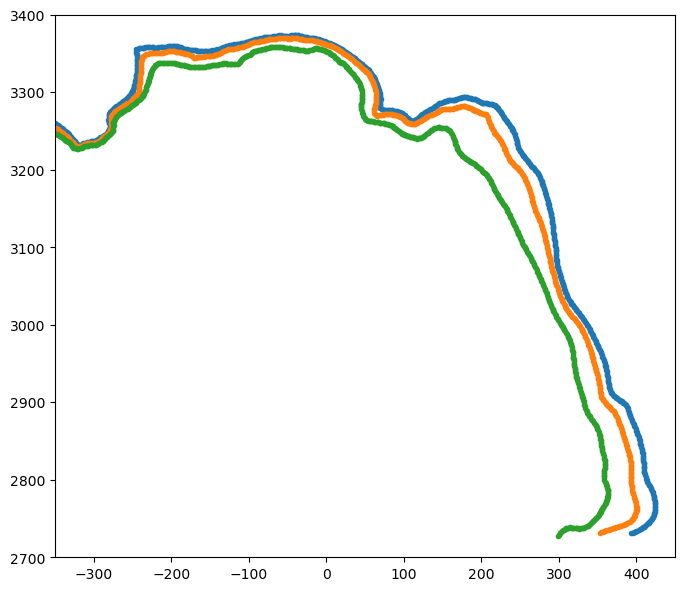

In [30]:
# Extract the vertices from the contour
contour_paths = contour_15.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After some fiddling, this looks like the region we need
contour15 = vertices[522:1450,:]

# Compute distances along the contour
dxyc = np.diff(contour15, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour15 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )



contour_paths = contour_20.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After messing around, these are the points we want:
contour20 = vertices[600:1480,:]

# Compute distances along the contour
dxyc = np.diff(contour20, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour20 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

contour_paths = contour_30.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# After messing around, these are the points we want:
contour30 = vertices[600:1480,:]

# Compute distances along the contour
dxyc = np.diff(contour30, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('contour30 point spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

fig, ax = plt.subplots(1,1, figsize=(8,8) )
ax.plot(contour15[:,0]/1000, contour15[:,1]/1000,'.')
ax.plot(contour20[:,0]/1000, contour20[:,1]/1000,'.')
ax.plot(contour30[:,0]/1000, contour30[:,1]/1000,'.')
ax.set_xlim( -350, 450 )
ax.set_ylim( 2700, 3400 )
ax.set_aspect('equal', adjustable='box')

In [7]:
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour15s = np.column_stack((
    gaussian_filter1d(contour15[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour15[:, 1], sigma=sigma)   # Smooth latitude
))

# Fit parametric spline (no smoothing)
tck, u = splprep([contour15s[:,0], contour15s[:,1]], s=0)

# Determine how many values are needed
contour_len = np.sum(np.linalg.norm(np.diff(contour15s, axis=0), axis=1))
delta = 2000
n_interp = int( contour_len / delta )+1 # fudge factor to get closer to 2000
print('Contour length (m): ', contour_len,'n points: ',n_interp)

# Create new u values for target spacing
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour15sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
delc = np.linalg.norm( np.diff(contour15sp, axis=0), axis=1 )
print('contour15sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

Contour length (m):  1299417.2066371338 n points:  650
contour15sp spacing: mean 2002.2, min 2002.0 max 2002.2


In [8]:
# Repeat for 30-m contour
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour30s = np.column_stack((
    gaussian_filter1d(contour30[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour30[:, 1], sigma=sigma)   # Smooth latitude
))

# Fit parametric spline (no smoothing)
tck, u = splprep([contour30s[:,0], contour30s[:,1]], s=0)

# Determine how many values are needed
contour_len = np.sum(np.linalg.norm(np.diff(contour30s, axis=0), axis=1))
delta = 2000
n_interp = int( contour_len / delta )+1 # fudge factor to get closer to 2000
print('Contour length (m): ', contour_len,'n points: ',n_interp)

# Create new u values for target spacing
u_new = np.linspace(0, 1, n_interp)

# Evaluate spline
x_new, y_new = splev(u_new, tck)
contour30sp = np.column_stack((x_new, y_new))

# Compute distances along the contour
delc = np.linalg.norm( np.diff(contour30sp, axis=0), axis=1 )
print('contour30sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(delc), np.min(delc), np.max(delc) ) )

Contour length (m):  1220275.119416454 n points:  611
contour30sp spacing: mean 2000.4, min 2000.3 max 2000.5


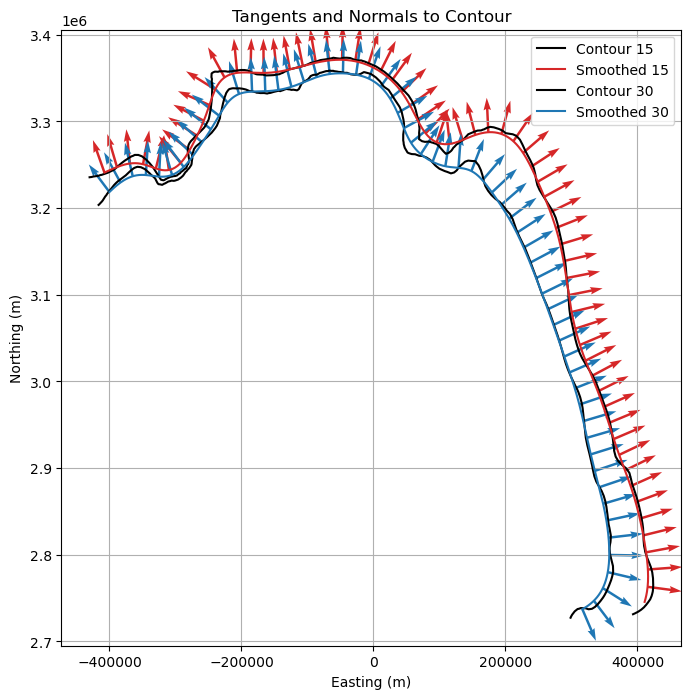

In [9]:
# Compute tangents
tangents15 = np.gradient(contour15sp, axis=0)  # Forward/backward difference for each point
tangents30 = np.gradient(contour30sp, axis=0)  # Forward/backward difference for each point

# Normalize tangents
tangents_norm15 = np.linalg.norm(tangents15, axis=1, keepdims=True)
tangents_unit15 = tangents15 / tangents_norm15
tangents_norm30 = np.linalg.norm(tangents30, axis=1, keepdims=True)
tangents_unit30 = tangents30 / tangents_norm30

# Compute normals
normals15 = np.zeros_like(tangents15)
normals15[:, 0] = tangents_unit15[:, 1]  # ty -> nx (swap and change sign)
normals15[:, 1] = -tangents_unit15[:, 0] # -tx -> ny
normals30 = np.zeros_like(tangents30)
normals30[:, 0] = tangents_unit30[:, 1]  # ty -> nx (swap and change sign)
normals30[:, 1] = -tangents_unit30[:, 0] # -tx -> ny

# Visualize tangents and normals
plt.figure(figsize=(8, 8))
plt.plot(contour15[:, 0], contour15[:, 1], 'k-', label='Contour 15')
plt.plot(contour15sp[:, 0], contour15sp[:, 1], '-', c='tab:red', label='Smoothed 15')
plt.plot(contour30[:, 0], contour30[:, 1], 'k-', label='Contour 30')
plt.plot(contour30sp[:, 0], contour30sp[:, 1], '-', c='tab:blue', label='Smoothed 30')

# Plot the normals, flip the normals by changing signs, plot every skip
skip = 10
plt.quiver(
    contour15sp[::skip, 0], contour15sp[::skip, 1], -normals15[::skip, 0], -normals15[::skip, 1],
    color = 'tab:red', width = .004)
plt.quiver(
    contour30sp[::skip, 0], contour30sp[::skip, 1], -normals30[::skip, 0], -normals30[::skip, 1],
    color = 'tab:blue', width = .004)
#    color='b', angles='xy', scale_units='xy', scale=2, width=.002, label='Normals')
plt.ylabel('Northing (m)')
plt.xlabel('Easting (m)')
plt.legend()
plt.title('Tangents and Normals to Contour')
plt.grid()
plt.show()

In [10]:
# Convert contour points back to lat/lon
transformerT = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)
contour15sp_lon, contour15sp_lat = transformerT.transform(contour15sp[:,0], contour15sp[:,1] )

# Create DataFrame
df = pd.DataFrame({
    "contour15s_lon": contour15sp_lon,
    "contour15s_lat": contour15sp_lat,
    "contour15s_x":contour15sp[:,0],
    "contour15s_y":contour15sp[:,1],
    "normals15_x": -normals15[:,0],
    "normals15_y": -normals15[:,1]
})

# Save to CSV
df.to_csv("contour15sp.csv", index=False)

print("CSV file saved as contour15sp.csv")

contour30sp_lon, contour30sp_lat = transformerT.transform(contour30sp[:,0], contour30sp[:,1] )

# Create DataFrame
df = pd.DataFrame({
    "contour30s_lon": contour30sp_lon,
    "contour30s_lat": contour30sp_lat,
    "contour30s_x":contour30sp[:,0],
    "contour30s_y":contour30sp[:,1],
    "normals30_x": -normals30[:,0],
    "normals30_y": -normals30[:,1]
})

# Save to CSV
df.to_csv("contour30sp.csv", index=False)

print("CSV file saved as contour30sp.csv")

CSV file saved as contour15sp.csv
CSV file saved as contour30sp.csv
